In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
from duneanalytics import DuneAnalytics

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py

In [4]:
# get Dune Analytics login credentials
MY_USERNAME = os.environ.get('DUNE_USERNAME')
MY_PASSWORD = os.environ.get('DUNE_PASSWORD')
dune = DuneAnalytics(MY_USERNAME, MY_PASSWORD)

## Input

In [5]:
chain = 'Avalanche'

In [6]:
reward_token = 'AVAX' if chain == 'Avalanche' else 'avax'
qid_price_yield = 1105079 if chain == 'Arbitrum' else 1109126
qid_swap_cost = 1095373 if chain == 'Arbitrum' else 1101895
qid_claim_cost = 1092684 if chain == 'Arbitrum' else 1102122 
qid_mint_cost = 1069676 if chain == 'Arbitrum' else 1102319 

## Read Data from Dune

In [7]:
def extract_frame_from_dune_data(dune_data):    
    dd = dune_data['data']['get_result_by_result_id']
    df = pd.json_normalize(dd, record_prefix='')
    df = df.loc[:, df.columns.str.startswith('data')]
    df.columns = df.columns.str.replace('data.', '', regex=False)
    # set `day` as index
    df['date'] = pd.to_datetime(df.day.str.replace('T.*', '', regex=True))
    del df['day']
    df = df.set_index('date')
    # drop the last row cuz it may not always be a full day
    return df.iloc[:-1, :]

In [8]:
dune.login()
dune.fetch_auth_token()
 
# fetch query result
price_yield = dune.query_result(dune.query_result_id(query_id=qid_price_yield))
swap_cost = dune.query_result(dune.query_result_id(query_id=qid_swap_cost))
claim_cost = dune.query_result(dune.query_result_id(query_id=qid_claim_cost))
mint_cost = dune.query_result(dune.query_result_id(query_id=qid_mint_cost))

In [9]:
# extract data frames
df_price_yield = extract_frame_from_dune_data(price_yield)
df_avax_usd_swap_cost = extract_frame_from_dune_data(swap_cost)
df_avax_reward_claim_cost = extract_frame_from_dune_data(claim_cost)
df_avax_glp_mint_cost = extract_frame_from_dune_data(mint_cost)

In [10]:
df_price_yield = (df_price_yield[['avax_price', 'eth_price', 'btc_price', 'glp_price', 
                                  'glp_supply', 'cumu_glp_supply', 
                                  'yield_usd', 'yield_avax']]
                      .assign(yield_per_share_usd = lambda x: x.yield_usd / x.cumu_glp_supply,
                              yield_per_share_avax = lambda x: x.yield_avax / x.cumu_glp_supply)
                 )
df_price_yield.tail()

,avax_price,eth_price,btc_price,glp_price,glp_supply,cumu_glp_supply,yield_usd,yield_avax,yield_per_share_usd,yield_per_share_avax
date,,,,,,,,,,
2022-07-22,24.8250,"1,577.1500","23,157.3600",0.7893,"-1,605,947.0769","104,041,503.9823","62,337.0805","2,511.0606",0.0006,0.0000
2022-07-23,23.6850,"1,540.0850","22,505.6850",0.7812,"-240,843.1409","103,800,660.8413","21,270.8517",898.0727,0.0002,0.0000
2022-07-24,24.0000,"1,599.2750","22,720.7150",0.7888,"1,099,884.4721","104,900,545.3134","23,289.1481",970.3812,0.0002,0.0000
2022-07-25,22.1300,"1,523.4700","21,953.2200",0.7727,"626,037.0134","105,526,582.3268","64,450.4847","2,912.3581",0.0006,0.0000
2022-07-26,20.5900,"1,413.3000","21,109.5850",0.7553,"-2,852,641.7466","102,673,940.5802","59,855.4881","2,907.0174",0.0006,0.0000


In [11]:
df_avax_usd_swap_cost.tail()

,fee_bp,gas_usd
date,,
2022-07-22,37.0000,0.2675
2022-07-23,32.0000,0.2667
2022-07-24,36.0000,0.2621
2022-07-25,37.0000,0.2385
2022-07-26,41.0000,0.2233


In [12]:
df_avax_reward_claim_cost.tail()

,gas_usd
date,
2022-07-22,0.6997
2022-07-23,0.6800
2022-07-24,0.6855
2022-07-25,0.6260
2022-07-26,0.5808


In [13]:
df_avax_glp_mint_cost.tail()

,fee_bp,gas_usd
date,,
2022-07-22,8.0000,0.7798
2022-07-23,8.0000,0.7560
2022-07-24,8.0000,0.7657
2022-07-25,8.0000,0.7038
2022-07-26,13.0000,0.6515


In [14]:
end_date = np.min([df_price_yield.index[-1], df_avax_usd_swap_cost.index[-1], df_avax_reward_claim_cost.index[-1], df_avax_glp_mint_cost.index[-1]])
end_date

Timestamp('2022-07-26 00:00:00')

## Set up 

allow users to enter their own numbers and see output

In [15]:
# user input
start_date = '2022-01-06'     # date of GLP purchase, can use a date string, for example, '2022-06-15'
start_capital = 10_000              # start with this much dollars
start_reserve = 1600                # dollars for paying tx costs

In [16]:
day1 = pd.to_datetime(start_date)
day2 = day1 + pd.Timedelta(1, 'day')
day_before_end = end_date - pd.Timedelta(1, 'day')
print('Start:', start_date)
print('Day 2:', day2.strftime('%Y-%m-%d'))
print('Day before last day:', day_before_end.strftime('%Y-%m-%d'))
print('End:', end_date.strftime('%Y-%m-%d'))

Start: 2022-01-06
Day 2: 2022-01-07
Day before last day: 2022-07-25
End: 2022-07-26


In [17]:
# beginning account value before any tx 
total_value_day1 = pd.Series(start_capital + start_reserve, index=pd.Index({day1}, name='date'))
total_value_day1

date
2022-01-06    11600
dtype: int64

In [18]:
# buy GLP with capital. what's the purchase price and tx cost?
init_price = df_price_yield.loc[start_date, 'glp_price']
init_fee_bp = df_avax_glp_mint_cost.loc[start_date, 'fee_bp']
init_fee = start_capital * init_fee_bp/1e4 # platform fee
init_gas = df_avax_glp_mint_cost.loc[start_date, 'gas_usd']

# pay tx cost
capital = start_capital - init_fee 
reserve = start_reserve - init_gas # always pay gas from reserve funds

# how many shares of GLP did we buy?
init_shares = capital / init_price

print('Purchase price: ${:.3f}'.format(init_price)) 
print('Platform fee paid: ${:.3f}'.format(init_fee))
print('Gas paid: ${:.3f}'.format(init_gas))
print('Shares: {:.4f}'.format(init_shares))

Purchase price: $1.166
Platform fee paid: $9.000
Gas paid: $2.718
Shares: 8567.2277


In [19]:
res = dict() # hold output growth paths

### Assumptions

- Buy shares at day end so we earn 0 yield on the day we buy GLP and earn full yield the next day.
- Sell shares at day end so we earn full yield on the last day.
- When reinvesting rewards, reinvest today's yield at today's price. Reinvestment also happens at day end so we earn 0 yield on the newly bought shares on the same day.

## Strategy 1: Accumulate rewards and Claim once at the end and Swap to USD

In [20]:
# from day 2 until the last day
df = (df_price_yield.loc[day2:, ['avax_price', 'glp_price', 'yield_per_share_avax']]
          .assign(my_glp_shares = init_shares,
                  my_yield_avax = lambda x: x.yield_per_share_avax * x.my_glp_shares,
                  my_cumu_yield_avax = lambda x: x.my_yield_avax.cumsum(),
                  my_cumu_yield_usd = lambda x: x.my_cumu_yield_avax * x.avax_price,
                  my_total_value = lambda x: x.glp_price * x.my_glp_shares + x.my_cumu_yield_usd + reserve)
     ) 
df

,avax_price,glp_price,yield_per_share_avax,my_glp_shares,my_yield_avax,my_cumu_yield_avax,my_cumu_yield_usd,my_total_value
date,,,,,,,,
2022-01-07,88.9700,1.1606,0.0000,"8,567.2277",0.1212,0.1212,10.7832,"11,550.8914"
2022-01-08,86.9000,1.1520,0.0000,"8,567.2277",0.1171,0.2383,20.7057,"11,487.1982"
2022-01-09,85.4300,1.1507,0.0000,"8,567.2277",0.3638,0.6020,51.4327,"11,506.6052"
2022-01-10,87.0200,1.1158,0.0001,"8,567.2277",0.5418,1.1439,99.5385,"11,256.3529"
2022-01-11,86.3350,1.1166,0.0000,"8,567.2277",0.3655,1.5094,130.3115,"11,293.9756"
...,...,...,...,...,...,...,...,...
2022-07-22,24.8250,0.7893,0.0000,"8,567.2277",0.2068,32.1309,797.6502,"9,157.1220"
2022-07-23,23.6850,0.7812,0.0000,"8,567.2277",0.0741,32.2050,762.7766,"9,052.3573"
2022-07-24,24.0000,0.7888,0.0000,"8,567.2277",0.0793,32.2843,774.8232,"9,130.2120"


In [21]:
# on the last day, what's the usd value of all the avax rewards we accumulated?
avax_rewards_value = df.loc[end_date, 'my_cumu_yield_usd']

# 1. claim all accumulated avax rewards. don't pay any fees to the platform, but need to pay gas 
fee = 0
gas = df_avax_reward_claim_cost.loc[end_date, 'gas_usd']

# 2. swap them to usd on the platform. need to pay a fee to the platform and gas 
fee += avax_rewards_value * (df_avax_usd_swap_cost.loc[end_date, 'fee_bp']/1e4)
gas += df_avax_usd_swap_cost.loc[end_date, 'gas_usd']

# update total value on last day
df.loc[end_date, 'my_total_value'] = df.loc[end_date, 'my_total_value'] - fee - gas

In [22]:
# collect the series of account values into res, don't forget beginning value
acct_value = pd.concat([total_value_day1, df.my_total_value])
print(acct_value)
name = 'Accumulate {} rewards, Claim them once on last day and Sell into USD'.format(reward_token)
res[name] = acct_value

date
2022-01-06   11,600.0000
2022-01-07   11,550.8914
2022-01-08   11,487.1982
2022-01-09   11,506.6052
2022-01-10   11,256.3529
                 ...    
2022-07-22    9,157.1220
2022-07-23    9,052.3573
2022-07-24    9,130.2120
2022-07-25    8,936.4373
2022-07-26    8,738.9864
Length: 202, dtype: float64


## Strategy 2: Claim and Sell Rewards into USD Daily

In [23]:
# from day 2 until the last day
df = (pd.merge(df_price_yield.loc[day2:, ['glp_price', 'yield_per_share_usd']], df_avax_reward_claim_cost, 
               left_index=True, right_index=True)
        .rename(columns = {'gas_usd': 'gas_claim'})
     )
df = (pd.merge(df, df_avax_usd_swap_cost, left_index=True, right_index=True)
        .rename(columns = {'gas_usd': 'gas_swap', 'fee_bp': 'fee_bp_swap'})
     )
df = (df.assign(my_glp_shares = init_shares,
                # no fees are collected by the platform when we claim rewards;
                # a fee is collected by the platform everytime we swap avax to usd 
                my_yield_usd_after_fees = lambda x: x.yield_per_share_usd * x.my_glp_shares * (1-x.fee_bp_swap/1e4),
                # need to pay gas everytime we claim and everytime we swap
                reserve = lambda x: reserve - x.gas_claim.cumsum() - x.gas_swap.cumsum(),
                # finally we calculate total account value each day
                my_total_value = lambda x: x.glp_price * x.my_glp_shares + x.my_yield_usd_after_fees + x.reserve
               )
     ) 
df

,glp_price,yield_per_share_usd,gas_claim,fee_bp_swap,gas_swap,my_glp_shares,my_yield_usd_after_fees,reserve,my_total_value
date,,,,,,,,,
2022-01-07,1.1606,0.0013,2.3793,7.5000,1.1722,"8,567.2277",10.7751,"1,593.7301","11,547.3319"
2022-01-08,1.1520,0.0012,2.1861,23.0000,0.7782,"8,567.2277",10.1500,"1,590.7658","11,470.1267"
2022-01-09,1.1507,0.0036,2.2408,17.0000,1.2233,"8,567.2277",31.0245,"1,587.3017","11,476.2171"
2022-01-10,1.1158,0.0055,2.2209,19.0000,1.4452,"8,567.2277",47.0590,"1,583.6356","11,190.2274"
2022-01-11,1.1166,0.0037,2.1811,28.0000,0.9406,"8,567.2277",31.4681,"1,580.5139","11,178.3647"
...,...,...,...,...,...,...,...,...,...
2022-07-22,0.7893,0.0006,0.6997,37.0000,0.2675,"8,567.2277",5.1141,875.7162,"7,643.0205"
2022-07-23,0.7812,0.0002,0.6800,32.0000,0.2667,"8,567.2277",1.7500,874.7695,"7,568.8187"
2022-07-24,0.7888,0.0002,0.6855,36.0000,0.2621,"8,567.2277",1.8952,873.8219,"7,633.8244"


In [24]:
if df.reserve.loc[end_date] < 0:
    print("To implement this strategy, you need at least ${} in reserve to pay gas.".format(np.ceil(reserve + abs(df.reserve.loc[end_date]))))

In [25]:
# collect the series of account values into res, don't forget beginning value
acct_value = pd.concat([total_value_day1, df.my_total_value])
print(acct_value)
name = 'Claim and Sell {} Rewards into USD Daily'.format(reward_token)
res[name] = acct_value

date
2022-01-06   11,600.0000
2022-01-07   11,547.3319
2022-01-08   11,470.1267
2022-01-09   11,476.2171
2022-01-10   11,190.2274
                 ...    
2022-07-22    7,643.0205
2022-07-23    7,568.8187
2022-07-24    7,633.8244
2022-07-25    7,497.6423
2022-07-26    7,347.8056
Length: 202, dtype: float64


## Strategy 3: Reinvest Rewards into GLP Daily

In [26]:
# from day 2 until the last day
df = (pd.merge(df_price_yield.loc[day2:, ['glp_price', 'yield_per_share_usd']], df_avax_reward_claim_cost, 
               left_index=True, right_index=True)
        .rename(columns = {'gas_usd': 'gas_claim'})
     )
df = (pd.merge(df, df_avax_glp_mint_cost, left_index=True, right_index=True)
        .rename(columns = {'gas_usd': 'gas_mint', 'fee_bp': 'fee_bp_mint'})
     )
df

,glp_price,yield_per_share_usd,gas_claim,fee_bp_mint,gas_mint
date,,,,,
2022-01-07,1.1606,0.0013,2.3793,7.0000,2.5712
2022-01-08,1.1520,0.0012,2.1861,25.0000,2.5314
2022-01-09,1.1507,0.0036,2.2408,20.0000,2.5067
2022-01-10,1.1158,0.0055,2.2209,10.0000,2.4385
2022-01-11,1.1166,0.0037,2.1811,23.0000,2.5058
...,...,...,...,...,...
2022-07-22,0.7893,0.0006,0.6997,8.0000,0.7798
2022-07-23,0.7812,0.0002,0.6800,8.0000,0.7560
2022-07-24,0.7888,0.0002,0.6855,8.0000,0.7657


In [27]:
daily_shares = [init_shares] # init_shares bought on end of day1
daily_reserve = [reserve] 
daily_acct_value = [total_value_day1.iloc[0]]

for i in range(len(df)): # 1st row of df is day2. 
    shares_yestoday = daily_shares[-1] 
    reserve_yestoday = daily_reserve[-1]
    
    # shares_yesterday  and full yield today                               
    yield_today = df.yield_per_share_usd[i] * shares_yestoday 

    # no fees are collected by the platform when we claim rewards;
    # a fee is collected by the platform everytime we mint glp
    yield_today_after_fees = yield_today * (1-df.fee_bp_mint[i]/1e4)
    # reinvest today's yield after fees at today's price
    price_today = df.glp_price[i]
    shares_bought_today = yield_today_after_fees / price_today       
    # how many shares we have at end of today
    shares_today = shares_yestoday + shares_bought_today 

    # also need to pay gas everytime we claim and everytime we mint glp
    reserve_today = reserve_yestoday - df.gas_claim[i] - df.gas_mint[i]

    # calculate account value today
    # note that today's yield after fees was distributed into shares_today, and reserve_today accounted for gas
    acct_value_today = shares_today * price_today + reserve_today
    
    # collect today's values
    daily_shares.append(shares_today)
    daily_reserve.append(reserve_today)
    daily_acct_value.append(acct_value_today)
    
# collect the series of account values into res
acct_value = pd.Series(daily_acct_value, index=df_price_yield.index)
print(acct_value)
name = 'Reinvest {} Rewards into GLP Daily'.format(reward_token)
res[name] = acct_value

date
2022-01-06   11,600.0000
2022-01-07   11,545.9334
2022-01-08   11,477.6793
2022-01-09   11,492.6686
2022-01-10   11,235.4294
                 ...    
2022-07-22    8,690.7164
2022-07-23    8,607.6625
2022-07-24    8,687.3375
2022-07-25    8,526.1185
2022-07-26    8,352.3987
Length: 202, dtype: float64


In [28]:
if daily_reserve[-1] < 0:
    print("To implement this strategy, you need at least ${} in reserve to pay gas.".format(np.ceil(start_reserve + abs(daily_reserve[-1]))))

## Compare

In [29]:
df = pd.DataFrame(res)
df

,"Accumulate AVAX rewards, Claim them once on last day and Sell into USD",Claim and Sell AVAX Rewards into USD Daily,Reinvest AVAX Rewards into GLP Daily
date,,,
2022-01-06,"11,600.0000","11,600.0000","11,600.0000"
2022-01-07,"11,550.8914","11,547.3319","11,545.9334"
2022-01-08,"11,487.1982","11,470.1267","11,477.6793"
2022-01-09,"11,506.6052","11,476.2171","11,492.6686"
2022-01-10,"11,256.3529","11,190.2274","11,235.4294"
...,...,...,...
2022-07-22,"9,157.1220","7,643.0205","8,690.7164"
2022-07-23,"9,052.3573","7,568.8187","8,607.6625"
2022-07-24,"9,130.2120","7,633.8244","8,687.3375"


In [30]:
df_long = df.stack().to_frame().reset_index()
df_long.columns = ['Date', 'Strategy', 'Investment Value']
df_long.head()

,Date,Strategy,Investment Value
0,2022-01-06,"Accumulate AVAX rewards, Claim them once on la...","11,600.0000"
1,2022-01-06,Claim and Sell AVAX Rewards into USD Daily,"11,600.0000"
2,2022-01-06,Reinvest AVAX Rewards into GLP Daily,"11,600.0000"
3,2022-01-07,"Accumulate AVAX rewards, Claim them once on la...","11,550.8914"
4,2022-01-07,Claim and Sell AVAX Rewards into USD Daily,"11,547.3319"


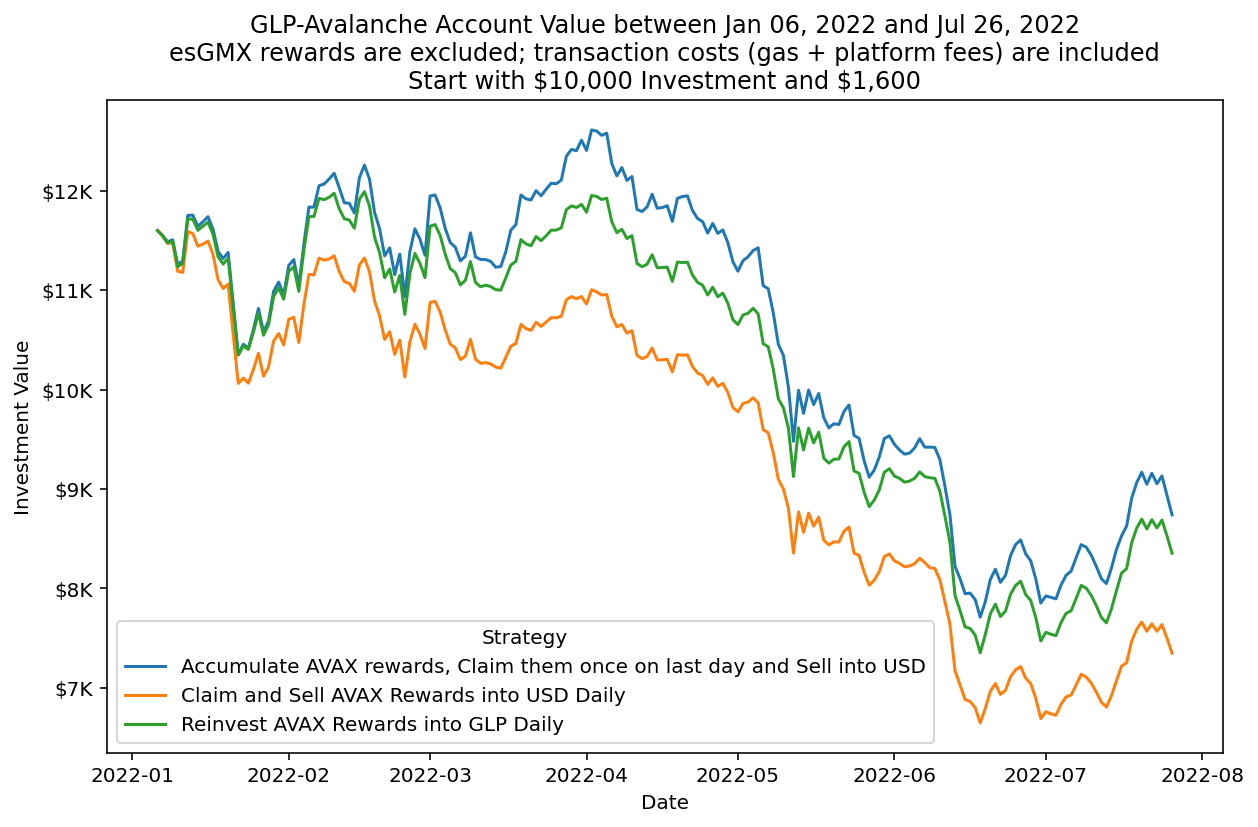

In [31]:
ax = sns.lineplot(data=df_long, x='Date', y='Investment Value', hue='Strategy')
tit1 = "GLP-{} Account Value between {} and {}\n".format(chain, day1.strftime('%b %d, %Y'), end_date.strftime('%b %d, %Y'))
tit2 = "esGMX rewards are excluded; transaction costs (gas + platform fees) are included\n"
tit3 = "Start with ${:,} Investment and \\${:,}".format(start_capital, start_reserve)
ax.set(title= tit1 + tit2 + tit3)
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)

fname = 'glp_strat_comp.png'
plt.savefig(os.path.join(png_dir, chain, fname), dpi=300);